# Playground

In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

image_width = 384
image_height = 384
image_depth = 1
num_classes = 3

In [215]:
# Read the data: Features and Label for 3 planes
features = pd.read_csv("input_files/W_Feature.csv") 
labels = pd.read_csv("input_files/W_Label.csv")

# Feature is the adc values
# Scale it such that each value is between 0 and 1
min_max_scaler = MinMaxScaler() 
features_scaled = min_max_scaler.fit_transform(features) 
features.loc[:,:] = features_scaled

features.head()

,Pixel 0,Pixel 1,Pixel 2,Pixel 3,Pixel 4,Pixel 5,Pixel 6,Pixel 7,Pixel 8,Pixel 9,...,Pixel 147446,Pixel 147447,Pixel 147448,Pixel 147449,Pixel 147450,Pixel 147451,Pixel 147452,Pixel 147453,Pixel 147454,Pixel 147455
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.181587,0.656629,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [310]:
# Get a Numpy representation of the DataFrame
X = features.values.reshape(features.shape[0], image_width, image_height, image_depth)
print(X.shape)
#X = X*np.zeros((1,1,3))
#print(X.shape)

#y = labels.values.reshape(labels.shape[0], image_width, image_height, image_depth)

y = labels.values

from keras.utils import np_utils
y = np_utils.to_categorical(y, num_classes=3)
y = y.reshape([labels.shape[0], image_width, image_height, num_classes])

print(y.shape)

(30, 384, 384, 1)
(30, 384, 384, 3)


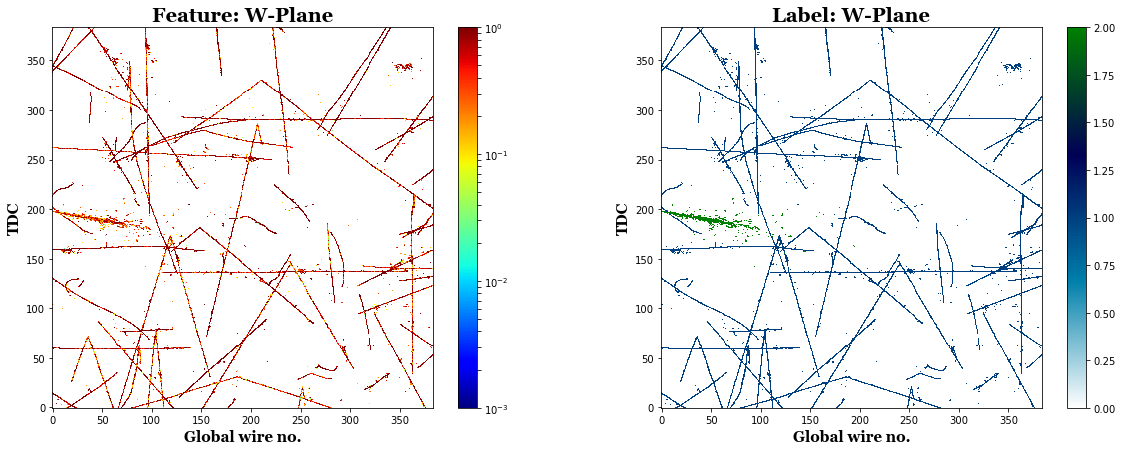

In [234]:
from matplotlib.colors import LogNorm
xImage = X.reshape(X.shape[0], image_width, image_height)
zImage = xImage[0][:,:]
yImage = y.reshape(y.shape[0], image_width, image_height)
zLabel = yImage[0][:,:]

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20,7), facecolor='w')
c0 = ax0.imshow(zImage, cmap='jet',interpolation='none', origin='lower', 
                norm=LogNorm(vmin=1E-3, vmax=abs(zImage).max()))
fig.colorbar(c0, ax=ax0)
ax0.set_xlabel("Global wire no.", fontsize=15, fontname='Georgia',fontweight='bold')
ax0.set_ylabel("TDC", fontsize=15, fontname='Georgia',fontweight='bold')
ax0.set_title('Feature: W-Plane', fontsize=20,fontname='Georgia',fontweight='bold')

c1= ax1.imshow(zLabel,cmap='ocean_r',interpolation='none', origin='lower', 
               vmin=abs(zLabel).min(), vmax=abs(zLabel).max())
fig.colorbar(c1, ax=ax1)
ax1.set_xlabel("Global wire no.", fontsize=15, fontname='Georgia',fontweight='bold')
ax1.set_ylabel("TDC", fontsize=15, fontname='Georgia',fontweight='bold')
ax1.set_title('Label: W-Plane', fontsize=20, fontname='Georgia',fontweight='bold')

plt.show()
fig.savefig('plots/W-PlaneFeatureAndLabel.pdf', bbox_inches='tight')

Label values: [0 1 2]
Label counts: [4139896  276898    6886]


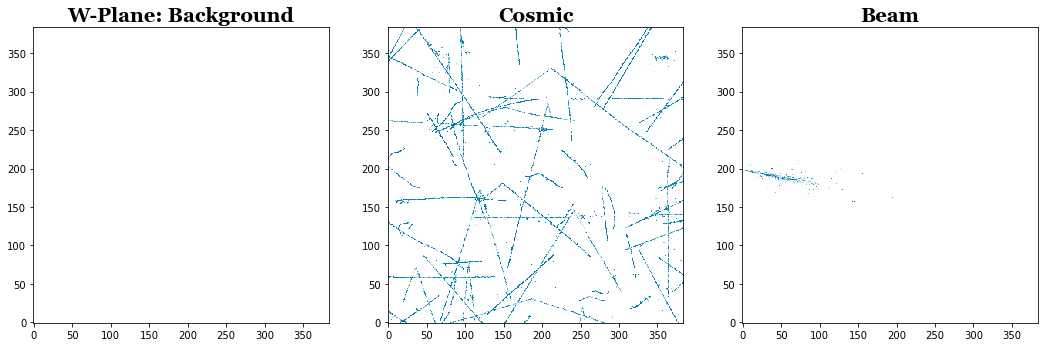

In [164]:
xImage = X.reshape(X.shape[0], image_width, image_height)
yImage = y.reshape(y.shape[0], image_width, image_height)

unique_values, unique_counts = np.unique(y, return_counts=True)
print('Label values:',unique_values)
print('Label counts:',unique_counts)

categories = ['W-Plane: Background','Cosmic','Beam']

fig, axes = plt.subplots(1, len(unique_values), figsize=(18,12), facecolor='w')
for index, value in enumerate(unique_values):
    ax = axes[index]
    mask = (yImage[0] == value)
    ax.imshow(xImage[0]*mask, interpolation='none', cmap='ocean_r', origin='lower',
              vmin=0., vmax=3.0)
    ax.set_title(categories[index],fontsize=20,fontname='Georgia',fontweight='bold')
plt.show()
fig.savefig('plots/W-planeBkgCosmicBeam.pdf', bbox_inches='tight')

# Build U-net model

In [293]:
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [315]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)        

    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [296]:
import tensorflow as tf
from keras import backend as K

smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [316]:
input_img = Input((image_height, image_width, 1))
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer = 'adam', 
                   loss = dice_coef_loss, 
                   metrics = [dice_coef, 'accuracy', 'mse'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 384, 384, 1)       0         
_________________________________________________________________
conv2d_286 (Conv2D)          (None, 384, 384, 16)      160       
_________________________________________________________________
batch_normalization_271 (Bat (None, 384, 384, 16)      64        
_________________________________________________________________
activation_369 (Activation)  (None, 384, 384, 16)      0         
_________________________________________________________________
conv2d_287 (Conv2D)          (None, 384, 384, 16)      2320      
_________________________________________________________________
batch_normalization_272 (Bat (None, 384, 384, 16)      64        
_________________________________________________________________
activation_370 (Activation)  (None, 384, 384, 16)      0         
__________

In [304]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('test.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [317]:
from skimage.transform import resize
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2018)

results = model.fit(X_train, y_train, batch_size=32, epochs=5, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))

Train on 25 samples, validate on 5 samples
Epoch 1/5


InvalidArgumentError: Incompatible shapes: [11059200] vs. [7372800]
	 [[Node: mul_3761 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](Reshape_34, Reshape_35)]]

Caused by op 'mul_3761', defined at:
  File "/anaconda2/envs/envAutoComplete/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda2/envs/envAutoComplete/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda2/envs/envAutoComplete/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/anaconda2/envs/envAutoComplete/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda2/envs/envAutoComplete/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/anaconda2/envs/envAutoComplete/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/anaconda2/envs/envAutoComplete/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/anaconda2/envs/envAutoComplete/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda2/envs/envAutoComplete/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/anaconda2/envs/envAutoComplete/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/anaconda2/envs/envAutoComplete/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/anaconda2/envs/envAutoComplete/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda2/envs/envAutoComplete/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/anaconda2/envs/envAutoComplete/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/anaconda2/envs/envAutoComplete/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/anaconda2/envs/envAutoComplete/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/anaconda2/envs/envAutoComplete/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/anaconda2/envs/envAutoComplete/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/anaconda2/envs/envAutoComplete/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/anaconda2/envs/envAutoComplete/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-316-33cee19b8b13>", line 6, in <module>
    metrics = [dice_coef, 'accuracy', 'mse'])
  File "/anaconda2/envs/envAutoComplete/lib/python3.5/site-packages/keras/engine/training.py", line 899, in compile
    sample_weight, mask)
  File "/anaconda2/envs/envAutoComplete/lib/python3.5/site-packages/keras/engine/training.py", line 430, in weighted
    score_array = fn(y_true, y_pred)
  File "<ipython-input-296-e038f6499b01>", line 12, in dice_coef_loss
    return -dice_coef(y_true, y_pred)
  File "<ipython-input-296-e038f6499b01>", line 8, in dice_coef
    intersection = K.sum(y_true_f * y_pred_f)
  File "/anaconda2/envs/envAutoComplete/lib/python3.5/site-packages/tensorflow/python/ops/math_ops.py", line 884, in binary_op_wrapper
    return func(x, y, name=name)
  File "/anaconda2/envs/envAutoComplete/lib/python3.5/site-packages/tensorflow/python/ops/math_ops.py", line 1105, in _mul_dispatch
    return gen_math_ops._mul(x, y, name=name)
  File "/anaconda2/envs/envAutoComplete/lib/python3.5/site-packages/tensorflow/python/ops/gen_math_ops.py", line 1625, in _mul
    result = _op_def_lib.apply_op("Mul", x=x, y=y, name=name)
  File "/anaconda2/envs/envAutoComplete/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/anaconda2/envs/envAutoComplete/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/anaconda2/envs/envAutoComplete/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1264, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Incompatible shapes: [11059200] vs. [7372800]
	 [[Node: mul_3761 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](Reshape_34, Reshape_35)]]


In [306]:
lab_pred = model.predict(X, verbose=1)

30/30 [==============================] - 27s


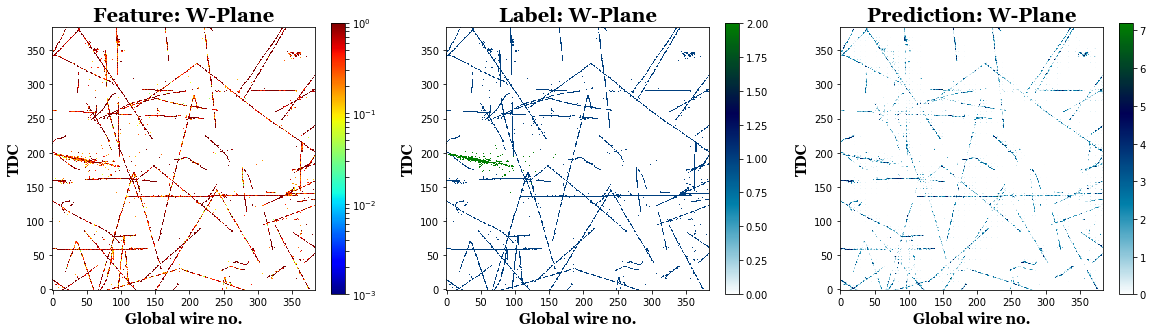

In [307]:
xPred = lab_pred.reshape(lab_pred.shape[0], image_width, image_height)
zPred = xPred[0][:,:]

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20,5), facecolor='w')
c0 = ax0.imshow(zImage, cmap='jet',interpolation='none', origin='lower', 
                norm=LogNorm(vmin=1E-3, vmax=abs(zImage).max()))
fig.colorbar(c0, ax=ax0)
ax0.set_xlabel("Global wire no.", fontsize=15, fontname='Georgia',fontweight='bold')
ax0.set_ylabel("TDC", fontsize=15, fontname='Georgia',fontweight='bold')
ax0.set_title('Feature: W-Plane', fontsize=20,fontname='Georgia',fontweight='bold')

c1= ax1.imshow(zLabel,cmap='ocean_r',interpolation='none', origin='lower', 
               vmin=abs(zLabel).min(), vmax=abs(zLabel).max())
fig.colorbar(c1, ax=ax1)
ax1.set_xlabel("Global wire no.", fontsize=15, fontname='Georgia',fontweight='bold')
ax1.set_ylabel("TDC", fontsize=15, fontname='Georgia',fontweight='bold')
ax1.set_title('Label: W-Plane', fontsize=20, fontname='Georgia',fontweight='bold')

c2= ax2.imshow(zPred, cmap='ocean_r',interpolation='none', origin='lower', 
               vmin=abs(zPred).min(), vmax=abs(zPred).max())
fig.colorbar(c2, ax=ax2)
ax2.set_xlabel("Global wire no.", fontsize=15, fontname='Georgia',fontweight='bold')
ax2.set_ylabel("TDC", fontsize=15, fontname='Georgia',fontweight='bold')
ax2.set_title('Prediction: W-Plane', fontsize=20, fontname='Georgia',fontweight='bold')

plt.show()
fig.savefig('plots/W-PlanePrediction.pdf', bbox_inches='tight')